In [8]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [9]:
#change parameters here
infile_path = "../Training 2/training_axial_crop_pat0.nii"
outfile_path = "reshapedHeart.nii.gz"
depth = 200
height = 200
width = 200
is_label_data = False

In [10]:
heart = sitk.ReadImage(infile_path)
heartArray = sitk.GetArrayFromImage(heart)
print(heartArray.shape)

(141, 207, 127)


In [11]:
#resize the image
img_stack_sm = np.zeros((len(heartArray), height, depth))

for idx in range(len(heartArray)):
    img = heartArray[idx, :, :]
    if is_label_data:
        img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_NEAREST)
    
    else:
        img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_CUBIC)
    img_stack_sm[idx, :, :] = img_sm
    

img_stack_sm2 = np.zeros((width, height, depth))

for idx in range(height):
    img = img_stack_sm[ :, idx, :]
    if is_label_data:
        img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_NEAREST)
    
    else:
        img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_CUBIC)
    img_stack_sm2[ :,idx, :] = img_sm

In [12]:
print(img_stack_sm2.shape)

(200, 200, 200)


In [13]:
reshapedHeart = sitk.GetImageFromArray(img_stack_sm2)

In [14]:
# Code from https://simpleitk-prototype.readthedocs.io/en/latest/user_guide/myshow.html
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()


def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


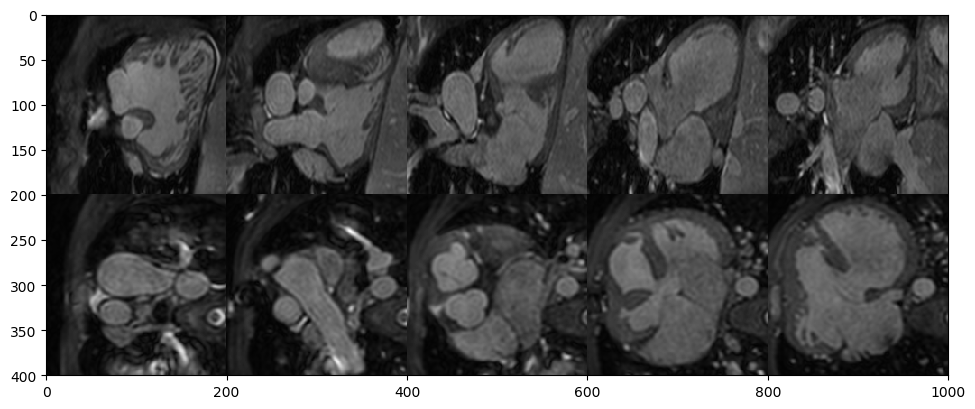

In [15]:
size = reshapedHeart.GetSize()
myshow3d(reshapedHeart, xslices=range(50, size[0] - 50, 20),
         yslices=range(50, size[1] - 50, 20), dpi=100)

In [16]:
sitk.WriteImage(reshapedHeart,outfile_path) 